<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Zhong\AppData\Local\Temp\ipykernel_26968\2836603806.py:16: SyntaxWarning: invalid escape sequence '\D'
  with open('E:\DataProcess\Yelp JSON\yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:


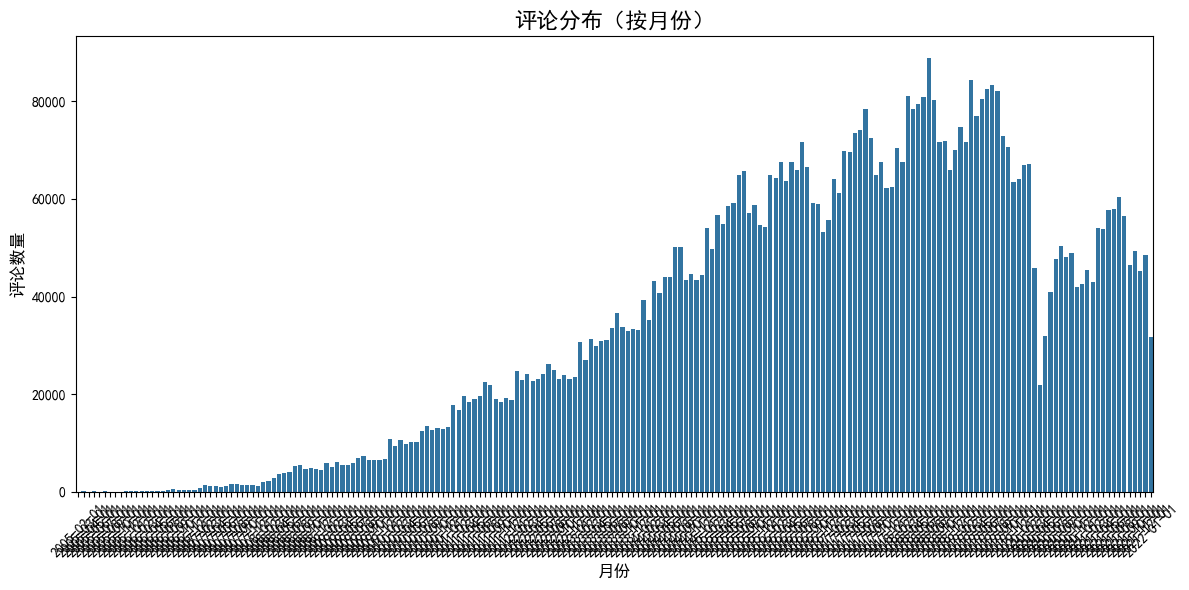

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 初始化一个字典来存储月份统计
month_counts = {}

# 逐行读取 JSON 文件
with open('E:\DataProcess\Yelp JSON\yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for line in f:
        try:
            # 解析每一行的 JSON 数据
            data = json.loads(line)
            # 提取日期字段
            date_str = data.get('date', '')
            # 将日期字符串解析为 datetime 对象
            date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            # 提取年月
            year_month = date_obj.strftime('%Y-%m')
            # 更新统计
            month_counts[year_month] = month_counts.get(year_month, 0) + 1
        except json.JSONDecodeError:
            # 跳过解析错误的行
            continue

# 将统计结果转换为 DataFrame
df = pd.DataFrame(list(month_counts.items()), columns=['month', 'count'])

# 将月份列转换为 datetime 类型以便排序
df['month'] = pd.to_datetime(df['month'])

# 按月份排序
df = df.sort_values('month')

# 绘制柱状图
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='count', data=df)
plt.xticks(rotation=45)
plt.title('评论分布（按月份）', fontsize=16)  # 中文标题
plt.xlabel('月份', fontsize=12)              # 中文X轴标签
plt.ylabel('评论数量', fontsize=12)           # 中文Y轴标签
plt.tight_layout()
plt.show()

In [2]:
# 导入所需的库
import json
import os
import pandas as pd
from tqdm import tqdm

# 设置文件路径
business_file_path = "E:/DataProcess/Yelp JSON/yelp_academic_dataset_business.json"
review_file_path = "E:/DataProcess/Yelp JSON/yelp_academic_dataset_review.json"
output_file_path = "E:/DataProcess/Yelp JSON/filtered_reviews.json"

# 读取商家信息，找出关闭的店铺
closed_business_ids = set()

with open(business_file_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Reading business file"):
        try:
            business = json.loads(line)
            if business.get("is_open", 1) == 0:  # 默认为1（open），如果字段不存在也认为是open
                closed_business_ids.add(business["business_id"])
        except json.JSONDecodeError as e:
            print(f"Error decoding business line: {e}")
            continue

print(f"Found {len(closed_business_ids)} closed businesses")

# 筛选评论文件，排除关闭店铺的评论
filtered_reviews = []

with open(review_file_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Filtering reviews"):
        try:
            review = json.loads(line)
            if review["business_id"] not in closed_business_ids:
                filtered_reviews.append(review)
        except json.JSONDecodeError as e:
            print(f"Error decoding review line: {e}")
            continue

print(f"Filtered {len(filtered_reviews)} reviews")

# 将筛选后的评论写入新的JSON文件
with open(output_file_path, 'w', encoding='utf-8') as f:
    for review in tqdm(filtered_reviews, desc="Writing filtered reviews"):
        json.dump(review, f)
        f.write('\n')

print(f"Filtered reviews saved to {output_file_path}")

Reading business file: 150346it [00:01, 106602.46it/s]


Found 30648 closed businesses


Filtering reviews: 6990280it [00:29, 234468.98it/s]


Filtered 5791234 reviews


Writing filtered reviews: 100%|██████████| 5791234/5791234 [01:25<00:00, 67636.62it/s]

Filtered reviews saved to E:/DataProcess/Yelp JSON/filtered_reviews.json


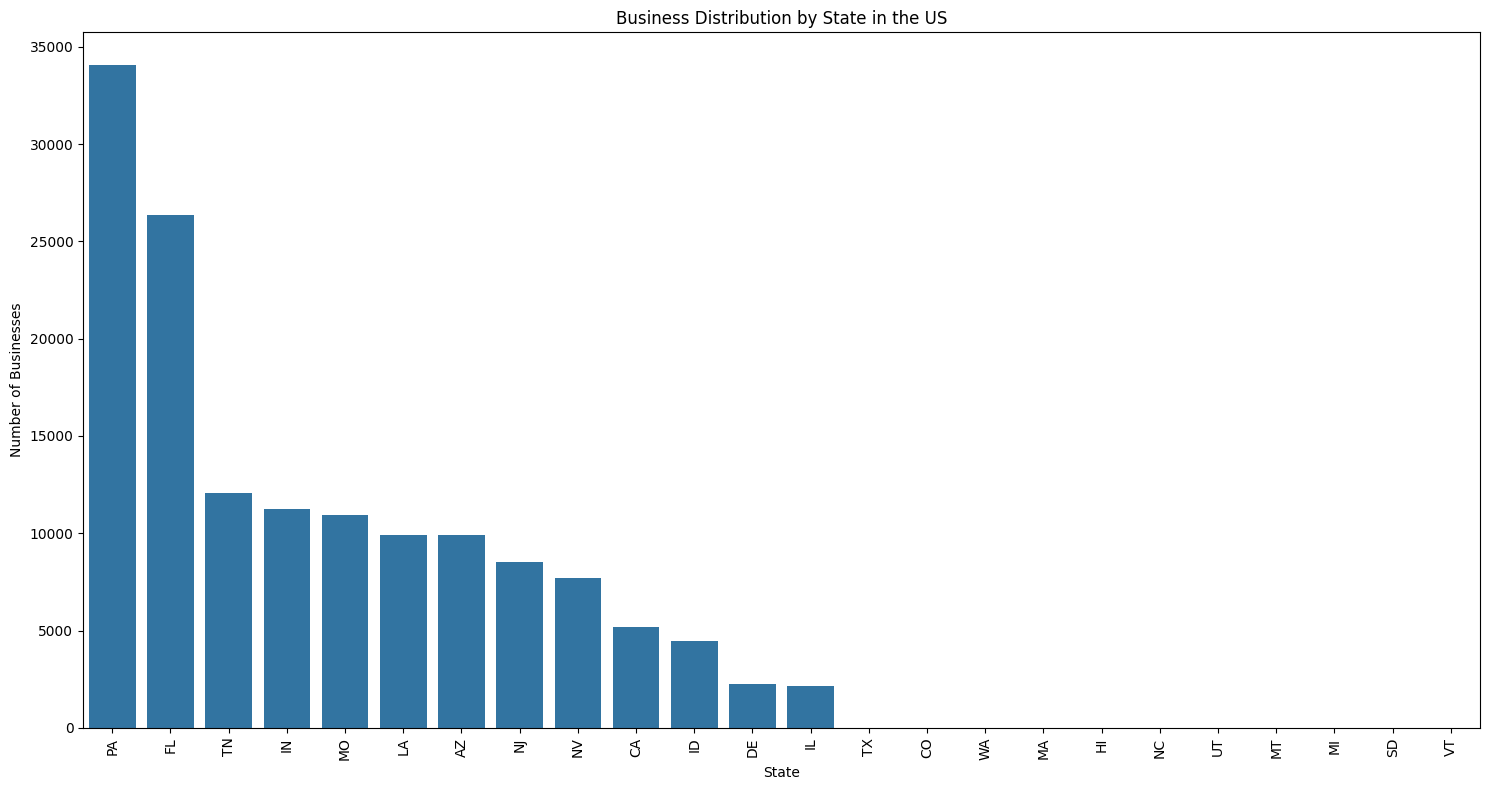

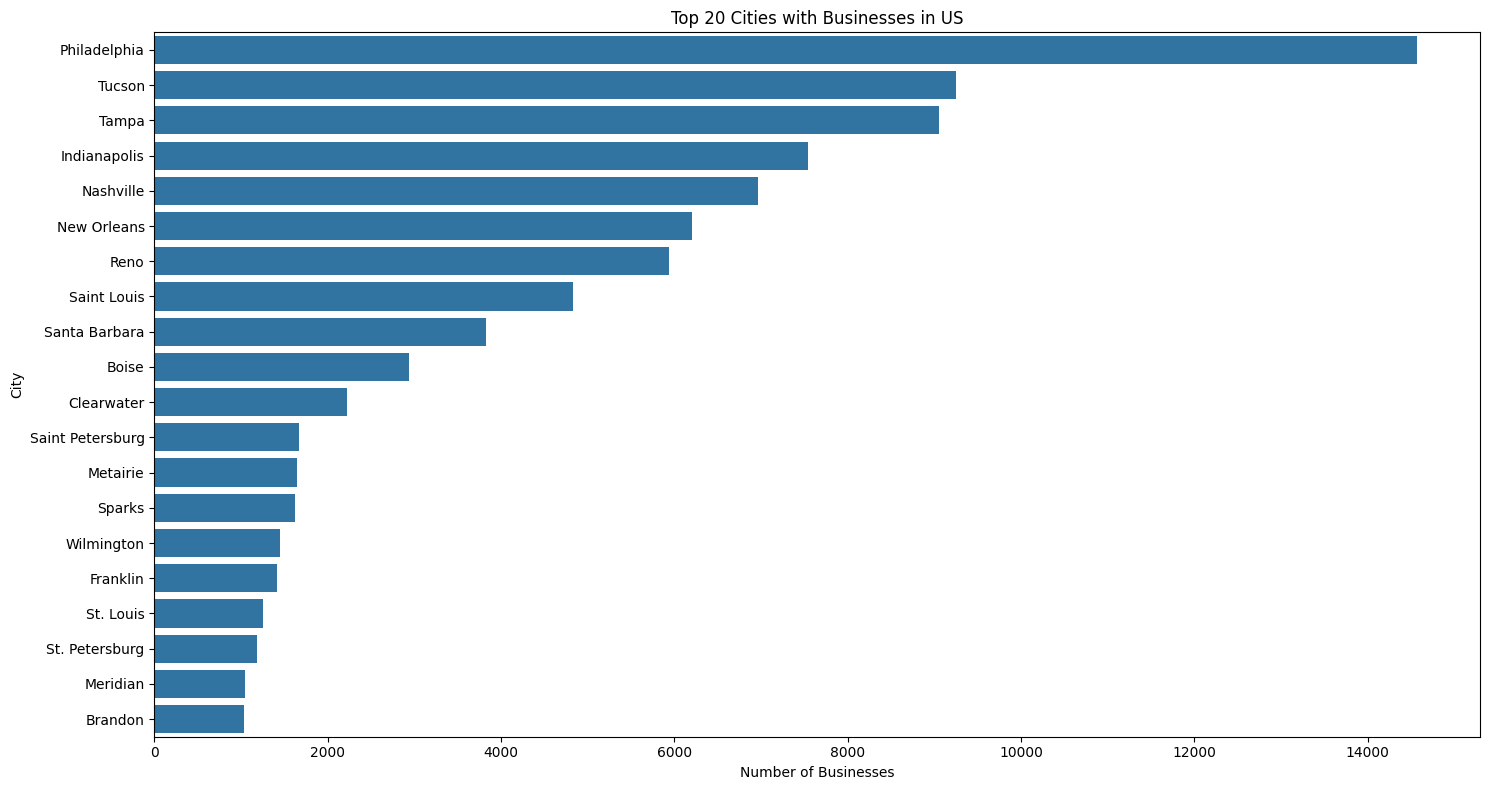

城市分布地图已保存为 us_business_cities_map.html
发现 72619 条状态不一致的记录
已保存 130209 条合格企业记录到 filtered_businesses.json
合格企业分布地图已保存为 filtered_businesses_map.html


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

business_file_path = "E:/DataProcess/Yelp JSON/yelp_academic_dataset_business.json"

# 1. 分批读取商家数据
def read_json_in_chunks(file_path, chunk_size=1000):
    data_chunk = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            data_chunk.append(json.loads(line))
            if (i + 1) % chunk_size == 0:
                yield pd.DataFrame(data_chunk)
                data_chunk = []
        # 处理剩余的数据
        if data_chunk:
            yield pd.DataFrame(data_chunk)

# 2. 定义国家映射
state_to_country = {
    'AL': 'US', 'AK': 'US', 'AZ': 'US', 'AR': 'US', 'CA': 'US', 'CO': 'US', 
    'CT': 'US', 'DE': 'US', 'FL': 'US', 'GA': 'US', 'HI': 'US', 'ID': 'US', 
    'IL': 'US', 'IN': 'US', 'IA': 'US', 'KS': 'US', 'KY': 'US', 'LA': 'US', 
    'ME': 'US', 'MD': 'US', 'MA': 'US', 'MI': 'US', 'MN': 'US', 'MS': 'US', 
    'MO': 'US', 'MT': 'US', 'NE': 'US', 'NV': 'US', 'NH': 'US', 'NJ': 'US', 
    'NM': 'US', 'NY': 'US', 'NC': 'US', 'ND': 'US', 'OH': 'US', 'OK': 'US', 
    'OR': 'US', 'PA': 'US', 'RI': 'US', 'SC': 'US', 'SD': 'US', 'TN': 'US', 
    'TX': 'US', 'UT': 'US', 'VT': 'US', 'VA': 'US', 'WA': 'US', 'WV': 'US', 
    'WI': 'US', 'WY': 'US', 'DC': 'US', 'AB': 'CA', 'BC': 'CA', 'MB': 'CA',
    'NB': 'CA', 'NL': 'CA', 'NS': 'CA', 'NT': 'CA', 'NU': 'CA', 'ON': 'CA',
    'PE': 'CA', 'QC': 'CA', 'SK': 'CA', 'YT': 'CA'
}

# 3. 初始化数据结构
all_data = []
selected_country = 'US'

# 4. 分批处理数据
for chunk in read_json_in_chunks(business_file_path):
    # 映射国家
    chunk['country'] = chunk['state'].map(state_to_country)
    
    # 筛选美国的数据
    us_chunk = chunk[chunk['country'] == selected_country]
    
    # 保存到总数据列表
    all_data.append(us_chunk)

# 5. 合并所有批次的数据
country_df = pd.concat(all_data)

# 6. 统计各州企业数量
state_counts = country_df['state'].value_counts()

# 7. 使用Seaborn绘制柱状图
plt.figure(figsize=(15, 8))
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.title('Business Distribution by State in the US')
plt.xlabel('State')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 8. 统计城市分布
city_counts = country_df['city'].value_counts().head(20)  # 取前20个城市

# 9. 绘制城市分布柱状图
plt.figure(figsize=(15, 8))
sns.barplot(x=city_counts.values, y=city_counts.index)
plt.title(f'Top 20 Cities with Businesses in {selected_country}')
plt.xlabel('Number of Businesses')
plt.ylabel('City')
plt.tight_layout()
plt.show()

# 10. 在地图上显示城市分布
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)  # 美国中心坐标

for city, count in city_counts.items():
    city_data = country_df[country_df['city'] == city]
    if not city_data.empty:
        first_entry = city_data.iloc[0]
        folium.CircleMarker(
            location=[first_entry['latitude'], first_entry['longitude']],
            radius=np.log(count) * 5,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"{city}: {count} businesses"
        ).add_to(us_map)

us_map.save('us_business_cities_map.html')
print("城市分布地图已保存为 us_business_cities_map.html")

# 11. 模拟2022年1月的营业状态数据
np.random.seed(42)
business_ids = country_df['business_id'].tolist()
jan_2022_status = {bid: np.random.choice([0, 1]) for bid in business_ids}

country_df['jan_2022_open'] = country_df['business_id'].map(jan_2022_status)
country_df['status_consistent'] = country_df['is_open'] == country_df['jan_2022_open']

inconsistent_count = country_df[~country_df['status_consistent']].shape[0]
print(f"发现 {inconsistent_count} 条状态不一致的记录")

# 12. 过滤掉不符合条件的企业
filtered_df = country_df[~((country_df['is_open'] == 0) & (country_df['jan_2022_open'] == 0))]

# 13. 保存到新JSON文件
filtered_df.to_json('filtered_businesses.json', orient='records', lines=True)
print(f"已保存 {filtered_df.shape[0]} 条合格企业记录到 filtered_businesses.json")

# 14. 绘制合格企业的分布地图
filtered_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

heat_data = [[row['latitude'], row['longitude']] for idx, row in filtered_df.iterrows()]
HeatMap(heat_data).add_to(filtered_map)

for idx, row in filtered_df.sample(1000).iterrows():
    popup_text = f"""
    <b>{row['name']}</b><br>
    Stars: {row['stars']}<br>
    Reviews: {row['review_count']}<br>
    Open: {'Yes' if row['is_open'] else 'No'}
    """
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='green' if row['is_open'] else 'red')
    ).add_to(filtered_map)

filtered_map.save('filtered_businesses_map.html')
print("合格企业分布地图已保存为 filtered_businesses_map.html")

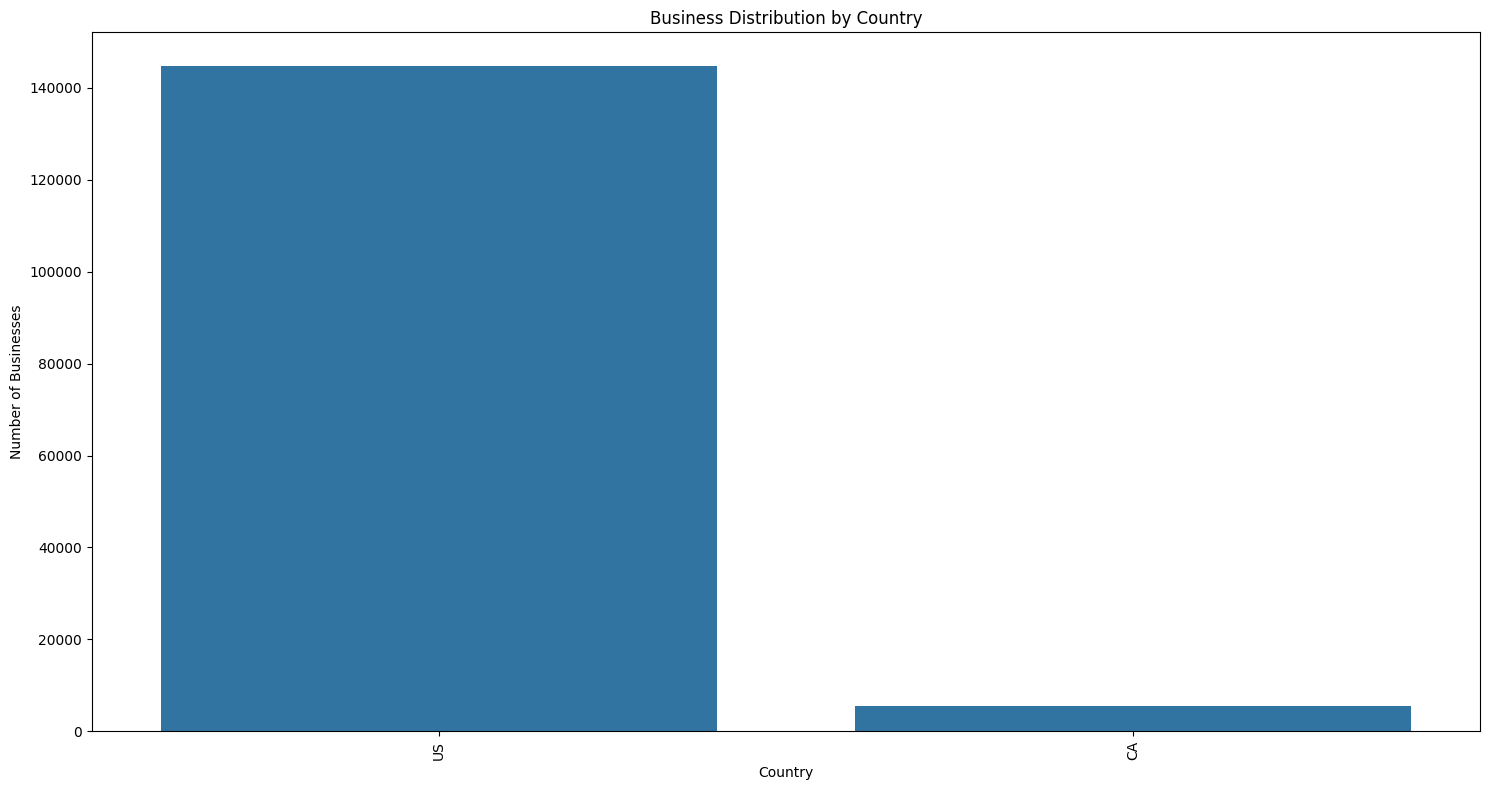

世界地图已保存为 world_business_map.html
已保存 150346 条企业记录（含国家信息）到 business_with_country.json


In [7]:
import json
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

business_file_path = "E:/DataProcess/Yelp JSON/yelp_academic_dataset_business.json"

# 1. 分批读取商家数据
def read_json_in_chunks(file_path, chunk_size=1000):
    data_chunk = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            data_chunk.append(json.loads(line))
            if (i + 1) % chunk_size == 0:
                yield pd.DataFrame(data_chunk)
                data_chunk = []
        # 处理剩余的数据
        if data_chunk:
            yield pd.DataFrame(data_chunk)

# 2. 定义国家映射
state_to_country = {
    'AL': 'US', 'AK': 'US', 'AZ': 'US', 'AR': 'US', 'CA': 'US', 'CO': 'US', 
    'CT': 'US', 'DE': 'US', 'FL': 'US', 'GA': 'US', 'HI': 'US', 'ID': 'US', 
    'IL': 'US', 'IN': 'US', 'IA': 'US', 'KS': 'US', 'KY': 'US', 'LA': 'US', 
    'ME': 'US', 'MD': 'US', 'MA': 'US', 'MI': 'US', 'MN': 'US', 'MS': 'US', 
    'MO': 'US', 'MT': 'US', 'NE': 'US', 'NV': 'US', 'NH': 'US', 'NJ': 'US', 
    'NM': 'US', 'NY': 'US', 'NC': 'US', 'ND': 'US', 'OH': 'US', 'OK': 'US', 
    'OR': 'US', 'PA': 'US', 'RI': 'US', 'SC': 'US', 'SD': 'US', 'TN': 'US', 
    'TX': 'US', 'UT': 'US', 'VT': 'US', 'VA': 'US', 'WA': 'US', 'WV': 'US', 
    'WI': 'US', 'WY': 'US', 'DC': 'US', 'AB': 'CA', 'BC': 'CA', 'MB': 'CA',
    'NB': 'CA', 'NL': 'CA', 'NS': 'CA', 'NT': 'CA', 'NU': 'CA', 'ON': 'CA',
    'PE': 'CA', 'QC': 'CA', 'SK': 'CA', 'YT': 'CA'
}

# 3. 分批处理数据并添加国家信息
all_data = []

for chunk in read_json_in_chunks(business_file_path):
    # 映射国家
    chunk['country'] = chunk['state'].map(state_to_country)
    
    # 保存到总数据列表
    all_data.append(chunk)

# 4. 合并所有批次的数据
business_df = pd.concat(all_data)

# 5. 统计各国企业数量
country_counts = business_df['country'].value_counts()

# 6. 绘制各国企业数量柱状图
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Business Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 7. 创建世界地图并添加热力图
world_map = folium.Map(location=[20, 0], zoom_start=2)

# 添加热力图
heat_data = [[row['latitude'], row['longitude']] for idx, row in business_df.iterrows() 
             if pd.notna(row['latitude']) and pd.notna(row['longitude'])]
HeatMap(heat_data).add_to(world_map)

# 添加国家标记
for country, count in country_counts.items():
    country_data = business_df[business_df['country'] == country]
    if not country_data.empty:
        # 使用该国家第一个商家的坐标作为代表坐标
        first_entry = country_data.iloc[0]
        folium.CircleMarker(
            location=[first_entry['latitude'], first_entry['longitude']],
            radius=np.log(count) * 2,  # 根据企业数量调整圆圈大小
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"{country}: {count} businesses"
        ).add_to(world_map)

world_map.save('world_business_map.html')
print("世界地图已保存为 world_business_map.html")

# 8. 保存处理后的数据到新的JSON文件
business_df.to_json('business_with_country.json', orient='records', lines=True)
print(f"已保存 {business_df.shape[0]} 条企业记录（含国家信息）到 business_with_country.json")

In [ ]:
import json
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import seaborn as sns
import time

business_file_path = "E:/DataProcess/Yelp JSON/yelp_academic_dataset_business.json"

# 1. 分批读取商家数据
def read_json_in_chunks(file_path, chunk_size=1000):
    data_chunk = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            data_chunk.append(json.loads(line))
            if (i + 1) % chunk_size == 0:
                yield pd.DataFrame(data_chunk)
                data_chunk = []
        # 处理剩余的数据
        if data_chunk:
            yield pd.DataFrame(data_chunk)

# 2. 初始化地理编码器
geolocator = Nominatim(user_agent="business_geocoder", timeout=10)
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1, max_retries=3)

# 3. 分批处理数据并添加国家信息
all_data = []
total_chunks = 0  # 总批次数量
processed_chunks = 0  # 已处理批次数量

# 计算总批次数量
for _ in read_json_in_chunks(business_file_path):
    total_chunks += 1

# 重新处理数据
for chunk in read_json_in_chunks(business_file_path):
    chunk_start_time = time.time()
    chunk_size = len(chunk)
    
    # 准备经纬度数据
    chunk['country'] = 'Unknown'
    for idx, row in chunk.iterrows():
        if pd.notna(row['latitude']) and pd.notna(row['longitude']):
            try:
                location = geocode(f"{row['latitude']}, {row['longitude']}")
                if location and 'country' in location.raw['address']:
                    chunk.at[idx, 'country'] = location.raw['address']['country']
                time.sleep(0.1)  # 添加短暂停顿避免请求过于频繁
            except Exception as e:
                print(f"Error geocoding {row['latitude']}, {row['longitude']}: {e}")
                continue
    
    # 保存到总数据列表
    all_data.append(chunk)
    
    # 打印进度
    processed_chunks += 1
    chunk_end_time = time.time()
    elapsed_time = chunk_end_time - chunk_start_time
    print(f"Processed chunk {processed_chunks}/{total_chunks} (Size: {chunk_size}), Time: {elapsed_time:.2f} seconds")

# 4. 合并所有批次的数据
business_df = pd.concat(all_data)

# 5. 统计各国企业数量
country_counts = business_df['country'].value_counts()

# 6. 绘制各国企业数量柱状图
plt.figure(figsize=(15, 8))
sns.barplot(x=country_counts.index, y=country_counts.values)
plt.title('Business Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Number of Businesses')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 7. 创建世界地图并添加热力图
world_map = folium.Map(location=[20, 0], zoom_start=2)

# 添加热力图
heat_data = [[row['latitude'], row['longitude']] for idx, row in business_df.iterrows() 
             if pd.notna(row['latitude']) and pd.notna(row['longitude'])]
HeatMap(heat_data).add_to(world_map)

# 添加国家标记
for country, count in country_counts.items():
    country_data = business_df[business_df['country'] == country]
    if not country_data.empty:
        # 使用该国家第一个商家的坐标作为代表坐标
        first_entry = country_data.iloc[0]
        folium.CircleMarker(
            location=[first_entry['latitude'], first_entry['longitude']],
            radius=np.log(count) * 2,  # 根据企业数量调整圆圈大小
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"{country}: {count} businesses"
        ).add_to(world_map)

world_map.save('world_business_map.html')
print("世界地图已保存为 world_business_map.html")

# 8. 保存处理后的数据到新的JSON文件
business_df.to_json('business_with_country.json', orient='records', lines=True)
print(f"已保存 {business_df.shape[0]} 条企业记录（含国家信息）到 business_with_country.json")